# Power analysis

In [1]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import yaml
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../../1_preprocess/'))
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../'))
from preprocess import _convert_oak_path
from DE_analysis_utils import *

In [2]:
sgrna_library_metadata = pd.read_csv('../../../metadata/sgRNA_library_curated.csv', index_col=0)

config_file = '../../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)
# Read config for both experiments
experiment_names = ['CD4iR1_Psomagen']
sample_info_list = []

for experiment_name in experiment_names:
    # Get config for this experiment
    config_exp = config[experiment_name]
    datadir = _convert_oak_path(config_exp['datadir'])
    
    # Find all postQC h5ad files in tmp directory
    tmp_dir = os.path.join(datadir, 'tmp')
    h5ad_files = [f'{tmp_dir}/{f}' for f in os.listdir(tmp_dir) if f.endswith('.postQC.DE_pseudobulk.h5ad')]

In [3]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config

{'selected_perturbed_genes': ['GATA3', 'KLF2', 'MED12', 'PTEN'],
 'subset_size': 5,
 'random_seeds': [432, 5435, 3214],
 'sample_ids': {'D1_Rest': {'datadir': '/oak/stanford/groups/pritch/users/emma/data/GWT/CD4iR1_Psomagen/'},
  'D2_Rest': {'datadir': '/oak/stanford/groups/pritch/users/emma/data/GWT/CD4iR1_Psomagen/'},
  'D3_Rest': {'datadir': '/oak/stanford/groups/pritch/users/emma/data/GWT/CD4iR2_Psomagen/'},
  'D4_Rest': {'datadir': '/oak/stanford/groups/pritch/users/emma/data/GWT/CD4iR2_Psomagen/'}}}

In [212]:
sample_id = 'D1_Rest'

# Read config
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

datadir = _convert_oak_path(config['sample_ids'][sample_id]['datadir'])
random_seeds = config['random_seeds']
selected_perturbed_genes = config['selected_perturbed_genes']
subset_size = config['subset_size']

# Get pseudobulk h5ad files
tmp_dir = os.path.join(datadir, 'tmp')
h5ad_files = [f'{tmp_dir}/{f}' for f in os.listdir(tmp_dir) if f.endswith('.postQC.DE_pseudobulk.h5ad')]
sample_h5ad_files = [x for x in h5ad_files if sample_id in x]
sample_h5ad_files

23

In [86]:
from tqdm.notebook import tqdm

def merge_pseudobulks(h5ad_files, sample_cols = ['cell_sample_id', 'guide_id'], selected_perturbed_genes = None, NTC_control_label = 'NTC'):
    # Get var table for all genes
    all_vars = [anndata.experimental.read_lazy(a).var.to_dataframe().copy() for a in h5ad_files]
    var_merged = pd.concat(all_vars)[['gene_ids', 'gene_name']].drop_duplicates()

    all_obs = []
    keep_cols = ['10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition',
        'guide_id', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type']
    for a in h5ad_files:
        a_obs = anndata.experimental.read_lazy(a).obs.to_dataframe()[keep_cols]
        a_obs["sample_id"] = a_obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
        all_obs.append(a_obs)
    obs_merged = pd.concat(all_obs).drop_duplicates()
    obs_merged = obs_merged.set_index('sample_id')
    if selected_perturbed_genes is not None:
        if NTC_control_label not in selected_perturbed_genes:
            selected_perturbed_genes.append(NTC_control_label)
        obs_merged = obs_merged[obs_merged.perturbed_gene_name.isin(selected_perturbed_genes)]

    # Read and sum pseudobulks
    merged_adata = sc.read_h5ad(h5ad_files[0])
    if selected_perturbed_genes is not None:
        merged_adata = merged_adata[merged_adata.obs.perturbed_gene_name.isin(selected_perturbed_genes)]
    merged_adata.obs["sample_id"] = merged_adata.obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
    n_cells_merged = merged_adata.obs[['sample_id', 'n_cells']].set_index('sample_id')

    for f in tqdm(h5ad_files[1:], desc="Merging pseudobulk files"):
        a = sc.read_h5ad(f)
        if selected_perturbed_genes is not None:
            a = a[a.obs.perturbed_gene_name.isin(selected_perturbed_genes)]
        a.obs["sample_id"] = a.obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
        # Keep track of n_cells
        n_cells_a = a.obs[['sample_id', 'n_cells']].set_index('sample_id')
        all_indices = n_cells_merged.index.union(n_cells_a.index)
        n_cells_merged = n_cells_merged.reindex(all_indices).fillna(0)
        n_cells_a = n_cells_a.reindex(all_indices).fillna(0)
        n_cells_merged = n_cells_merged + n_cells_a
        merged_adata = anndata.concat([merged_adata, a], join='outer')
        merged_adata = sc.get.aggregate(merged_adata, by='sample_id', func='sum', layer='sum')

    merged_adata.var = var_merged.loc[merged_adata.var_names]
    merged_adata.obs = obs_merged.loc[merged_adata.obs_names]
    merged_adata.obs['n_cells'] = n_cells_merged.loc[merged_adata.obs_names]
    return(merged_adata)


def merge_pseudobulk_from_list(adatas, sample_cols = ['cell_sample_id', 'guide_id']):
    for a in adatas:
        a.obs["sample_id"] = a.obs[sample_cols].apply(lambda x: "_".join(x), axis=1)

    all_vars = [a.var for a in adatas]
    var_merged = pd.concat(all_vars)[['gene_ids', 'gene_name']].drop_duplicates()
    all_obs = [a.obs.drop('n_cells', axis=1) for a in adatas]
    obs_merged = pd.concat(all_obs).drop_duplicates()
    obs_merged = obs_merged.set_index('sample_id')
    
    # Keep track of n_cells
    n_cells_merged = pd.concat([a.obs[['n_cells']] for a in adatas], axis=1).fillna(0).sum(1)
    merged_adata = anndata.concat(adatas, join='outer')
    merged_adata = sc.get.aggregate(merged_adata, by='sample_id', func='sum', layer='sum')

    merged_adata.var = var_merged.loc[merged_adata.var_names]
    merged_adata.obs = obs_merged.loc[merged_adata.obs_names]
    merged_adata.obs['n_cells'] = n_cells_merged.loc[merged_adata.obs_names]
    return(merged_adata)

In [ ]:
selected_perturbed_genes = ['GATA3', 'KLF2', 'MED12', 'PTEN']
subset_size = 5
random_seed = 324
np.random.seed(random_seed)

sample_id = 'D1_Stim8hr'
sample_h5ad_files = [x for x in h5ad_files if sample_id in x]

# Split files into 5 non-overlapping sets of ~5 files each
all_indices = np.arange(len(sample_h5ad_files))
np.random.shuffle(all_indices)
split_indices = [all_indices[i:i+subset_size] for i in range(0, len(all_indices), subset_size)]

merged_adatas = []
for ixs in split_indices:
    subset_sample_h5ad_files = [sample_h5ad_files[i] for i in ixs] # Use first set of 5
    merged_adata = merge_pseudobulks(subset_sample_h5ad_files, selected_perturbed_genes = selected_perturbed_genes)
    merged_adatas.append(merged_adata)

# Sum different number of lanes
power_analysis_adatas = {f'split{i}':merge_pseudobulk_from_list(merged_adatas[0:i]) for i in np.arange(1, len(merged_adatas)+1)}

# Store objects
power_analysis_mdata = md.MuData(power_analysis_adatas)
power_analysis_mdata.write_h5mu(f'./power_analysis.{sample_id}.seed{random_seed}.h5mu')


Merging pseudobulk files:   0%|          | 0/4 [00:00<?, ?it/s]

Merging pseudobulk files:   0%|          | 0/4 [00:00<?, ?it/s]

Merging pseudobulk files:   0%|          | 0/4 [00:00<?, ?it/s]

Merging pseudobulk files:   0%|          | 0/4 [00:00<?, ?it/s]

Merging pseudobulk files:   0%|          | 0/2 [00:00<?, ?it/s]

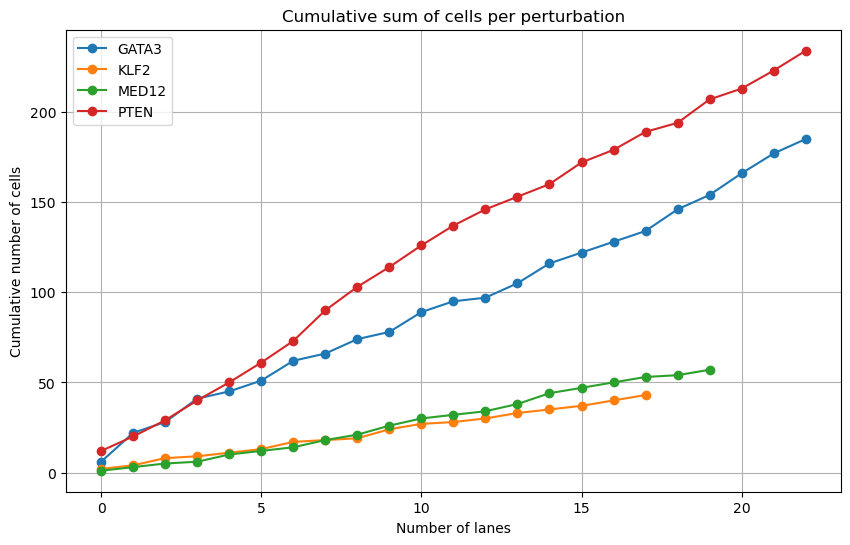

In [77]:
# Group by perturbed_gene_name and lane_id, get sum of n_cells
grouped_cells = obs_merged[obs_merged['perturbed_gene_name'].isin(selected_perturbed_genes)].groupby(['perturbed_gene_name', 'lane_id'])['n_cells'].sum()

# Convert to DataFrame and calculate cumulative sum within each perturbed_gene_name
df = grouped_cells.reset_index()
df['cumsum'] = df.groupby('perturbed_gene_name')['n_cells'].cumsum()

# Plot cumulative sums
plt.figure(figsize=(10,6))
for gene in selected_perturbed_genes:
    gene_data = df[df['perturbed_gene_name'] == gene]
    plt.plot(range(len(gene_data)), gene_data['cumsum'], marker='o', label=gene)

plt.xlabel('Number of lanes')
plt.ylabel('Cumulative number of cells')
plt.title('Cumulative sum of cells per perturbation')
plt.legend()
plt.grid(True)

In [80]:
from itertools import permutations
# Read config file
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

sample_ids = config['sample_ids'].keys()

adata_lists = {}
for s in sample_ids:
    mdata = md.read_h5mu(f'power_analysis.{s}.h5mu')
    for k in mdata.mod:
        mdata[k].obs['n_lanes'] = int(k.split('_')[0].replace('split', '')) * 5
        mdata[k].obs['seed'] = k.split('_')[1]
        mdata[k].obs['seed'] = k.split('_')[1]
        if k not in adata_lists.keys():
            adata_lists[k] = []    
        adata_lists[k].append(mdata[k])

n_donors = len(sample_ids)
all_combs = True
if all_combs:
    combs = []
    sizes = [i for i in range(1,n_donors+1)]
    for size in sizes:
        size_combs = set(frozenset(p) for p in permutations([0,1,2,3], size))
        combs.extend(tuple(sorted(p)) for p in size_combs)
else:
    combs = [
        (0,), (1,), (2,), (3,),
        (0,1), (2,3),
        (0,1,2), (3,1,2),
        (0,1,2,3)
    ]

power_analysis_adatas = {}
for k,ls in tqdm(adata_lists.items(), desc="Processing adata lists"):
    k_adata = anndata.concat(ls)
    k_adata.obs['power_analysis_key'] = k
    all_donors = sum([a.obs['donor_id'].unique().tolist() for a in ls],[])
    for i, c in enumerate(combs):
        c_donors = [all_donors[i] for i in c]
        k_adata.obs[f'donor_comb_{i}'] = k_adata.obs[f'donor_id'].isin(c_donors)
    power_analysis_adatas[k] = k_adata
    k_adata.write_h5ad(f'power_analysis.{k}.h5ad')

Processing adata lists: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


Run DE tests w SLURM

In [147]:
for k in adata_lists.keys():
    print(f'sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py {k}"')

sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split1_seed432"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split2_seed432"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split3_seed432"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split4_seed432"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split5_seed432"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split1_seed5435"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split2_seed5435"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split3_seed5435"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split4_seed5435"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split5_seed5435"
sbatch --cpus-per-task=16 --mem=24G --wrap="python power_analysis_test.py split1_seed3214"
sbat

## Parse results

In [86]:
target_id_to_name = {
 'ENSG00000107485': 'GATA3',
 'ENSG00000127528': 'KLF2',
 'ENSG00000184634': 'MED12',
 'ENSG00000171862': 'PTEN'
 }

# Find all DE results files
de_results_files = [f for f in os.listdir() if f.endswith('DE_results.csv')]
all_de_res = pd.DataFrame()
for f in de_results_files:
    de_res = pd.read_csv(f, index_col=0)
    de_res['target_name'] = de_res['target'].map(target_id_to_name)
    de_res['test'] = de_res['target_name'].astype(str) + '_' + de_res['variable'].astype(str)
    all_de_res = pd.concat([all_de_res, de_res])

## Evaluation metrics

In [95]:
def DE_goldstandard_f1(test_results, gs_results, pval_threshold=0.1):
    """
    Compute F1 score for recall of significant DE genes from gold standard
    
    Args:
        test_results (pd.DataFrame): DE results from test dataset
        gs_results (pd.DataFrame): DE results from gold standard dataset
        pval_threshold (float): Adjusted p-value threshold for significance
        
    Returns:
        float: F1 score
    """
    # Get significant genes from gold standard and test
    sig_gs_genes = set(gs_results[gs_results['adj_p_value'] < pval_threshold]['test'])
    sig_test_genes = set(test_results[test_results['adj_p_value'] < pval_threshold]['test'])
    
    # Calculate precision and recall
    true_positives = len(sig_gs_genes.intersection(sig_test_genes))
    false_positives = len(sig_test_genes - sig_gs_genes)
    false_negatives = len(sig_gs_genes - sig_test_genes)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1

def DE_goldstandard_lfc_corr(test_results, gs_results, pval_threshold=0.1, effect_size='log_fc'):
    """
    Compute correlation of effect sizes between test and gold standard results
    
    Args:
        test_results (pd.DataFrame): DE results from test dataset
        gs_results (pd.DataFrame): DE results from gold standard dataset
        pval_threshold (float): Adjusted p-value threshold for significance
        effect_size (str): Column name for effect size measure, defaults to 'log_fc'
        
    Returns:
        float: Pearson correlation coefficient of effect sizes
    """
    # Merge test and gold standard results on the test column
    merged_results = pd.merge(
        test_results[['test', effect_size]], 
        gs_results[['test', effect_size]], 
        on='test',
        suffixes=('_test', '_gs')
    )['test', f'{effect_size}_gs', f'{effect_size}_test'].dropna()
    
    # Calculate correlation between effect sizes
    correlation, pvalue = scipy.stats.pearsonr(merged_results[f'{effect_size}_test'], merged_results[f'{effect_size}_gs'])
    
    return correlation, pvalue

Get gold standard from arrayed bulk RNA-seq 

In [96]:
Freimer_results = sc.read_h5ad('../data/Freimer_et_al_DE.h5ad')
lfc_df = sc.get.obs_df(
    Freimer_results[Freimer_results.obs['target_gene'].isin(target_id_to_name.values())], 
    keys=Freimer_results.var_names.tolist(),
    layer='log_fc').melt(ignore_index=False, 
                          var_name='gene', 
                          value_name='log_fc')
pval_df = sc.get.obs_df(
    Freimer_results[Freimer_results.obs['target_gene'].isin(target_id_to_name.values())], 
    keys=Freimer_results.var_names.tolist(),
    layer='adj_p_value').melt(ignore_index=False, 
                          var_name='gene', 
                          value_name='adj_p_value')
freimer_de_res = pd.merge(lfc_df.reset_index(), pval_df.reset_index())
freimer_de_res['test'] = freimer_de_res['index'].astype(str) + "_" + freimer_de_res['gene'].astype(str)

In [97]:
gs_de_results

,index,gene,log_fc,adj_p_value,test
0,GATA3,ENSG00000000003,0.022508,NaN,GATA3_ENSG00000000003
8,GATA3,ENSG00000000419,-0.058584,0.760972,GATA3_ENSG00000000419
12,GATA3,ENSG00000000457,-0.114916,0.614634,GATA3_ENSG00000000457
16,GATA3,ENSG00000000460,-0.086987,0.652459,GATA3_ENSG00000000460
20,GATA3,ENSG00000000938,-2.481707,NaN,GATA3_ENSG00000000938
...,...,...,...,...,...
233376,GATA3,ENSG00000285891,NaN,NaN,GATA3_ENSG00000285891
233548,GATA3,ENSG00000285938,-0.578527,NaN,GATA3_ENSG00000285938
233680,GATA3,ENSG00000285976,-1.093622,NaN,GATA3_ENSG00000285976
234140,GATA3,ENSG00000286095,NaN,NaN,GATA3_ENSG00000286095


In [98]:
all_keys = all_de_res['power_analysis_key'].unique()
all_combs = all_de_res['donor_comb'].unique()

results_df = pd.DataFrame(columns=['power_analysis_key', 'donor_comb', 'f1_score', 'lfc_correlation', 'correlation_pvalue'])
for target in target_id_to_name.values():
    target_de_res = all_de_res[all_de_res['target_name'] == target].copy()
    gs_de_results = freimer_de_res[(freimer_de_res['index'] == target) & (freimer_de_res.gene.isin(target_de_res['variable']))]

    for k in all_keys:
        for c in all_combs:
            test_de_results = target_de_res[(target_de_res['power_analysis_key'] == k) & (target_de_res['donor_comb'] == c)]
            
            # Calculate metrics
            f1 = DE_goldstandard_f1(test_de_results, gs_de_results)
            correlation, pvalue = DE_goldstandard_lfc_corr(test_de_results, gs_de_results)
            
            # Add results to dataframe
            results_df = pd.concat([results_df, pd.DataFrame({
                'power_analysis_key': [k],
                'donor_comb': [c], 
                'f1_score': [f1],
                'lfc_correlation': [correlation],
                'correlation_pvalue': [pvalue],
                'n_cells':test_de_results['n_cells'].unique()[0],
                'n_donors':test_de_results['n_donors'].unique()[0],
                'target':target
            })])

KeyError: ('test', 'log_fc_gs', 'log_fc_test')

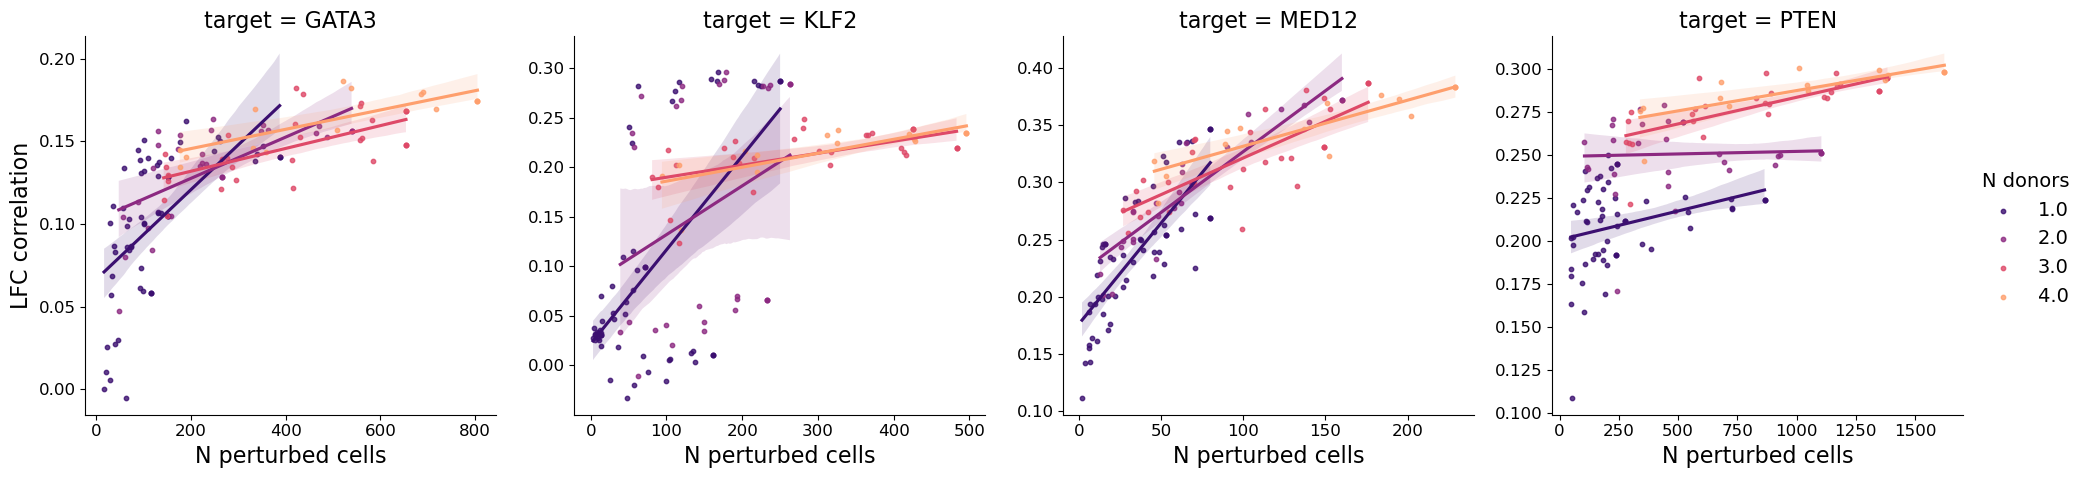

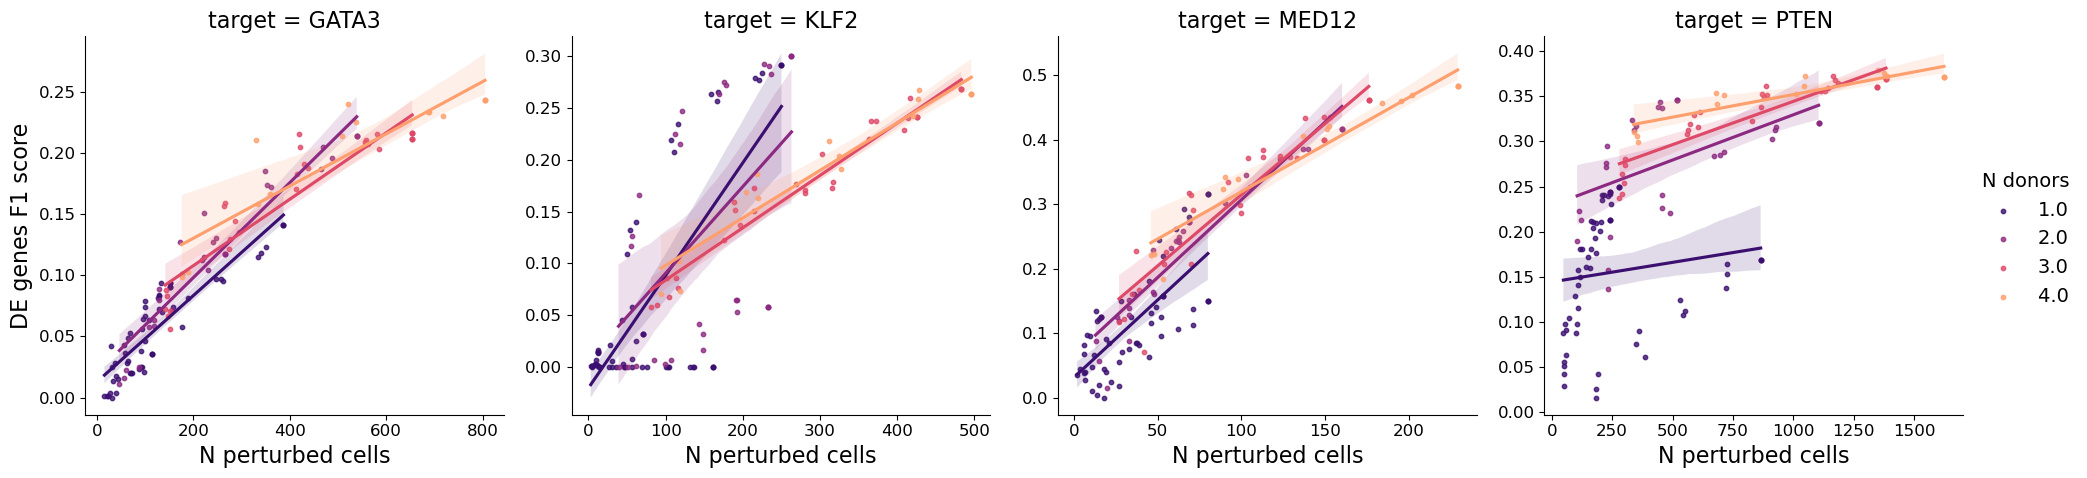

In [81]:
results_df['n_cells_repl'] = results_df['n_cells'] / results_df['n_donors']
results_df['N donors'] = results_df['n_donors']

# Create scatter plot with trend lines
plt.rcParams.update({'font.size': 14})  # base font size
plt.rcParams.update({'axes.labelsize': 16})  # axis labels
plt.rcParams.update({'xtick.labelsize': 12})  # x tick labels
plt.rcParams.update({'ytick.labelsize': 12})  # y tick labels

metrics_labels = {
    'lfc_correlation':'LFC correlation',
    'f1_score':'DE genes F1 score',
}
for m,l in metrics_labels.items():
    g = sns.lmplot(
        data=results_df,
        x='n_cells',
        y=m,
        hue='N donors',
        palette='magma',
        scatter=True,
        ci=95,
        col = 'target',
        scatter_kws={'s': 10},
        # lowess=True,
        sharex=False,
        sharey=False
    )
    g.set_axis_labels('N perturbed cells', l)
    plt.savefig(f'../results/power_analysis.arrayed_gold_standard.{m}.pdf')
    plt.savefig(f'../results/power_analysis.arrayed_gold_standard.{m}.png')


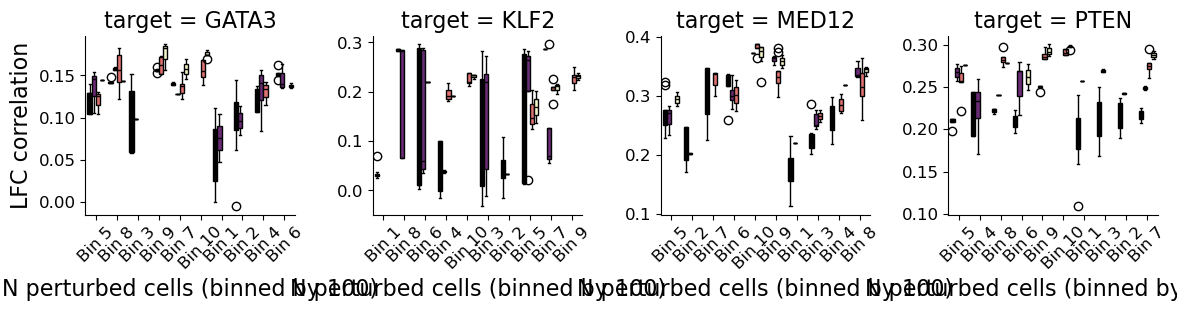

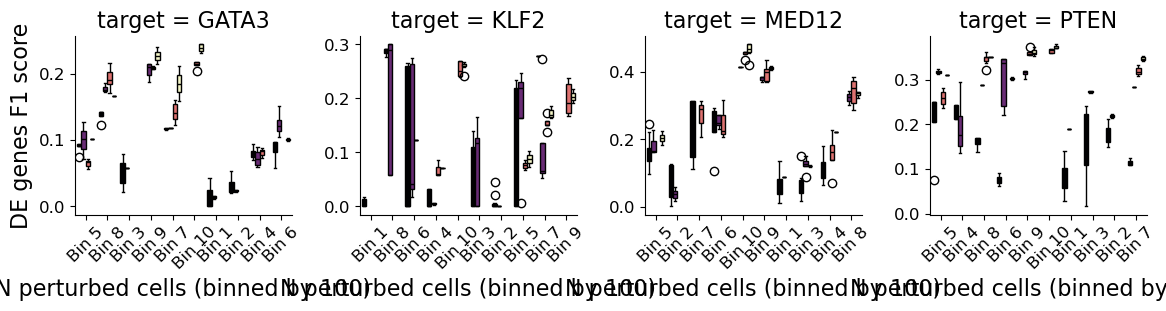

In [63]:
results_df['n_cells_repl'] = results_df['n_cells'] / results_df['n_donors']
results_df['N donors'] = results_df['n_donors']

# Create scatter plot with trend lines
plt.rcParams.update({'font.size': 14})  # base font size
plt.rcParams.update({'axes.labelsize': 16})  # axis labels
plt.rcParams.update({'xtick.labelsize': 12})  # x tick labels
plt.rcParams.update({'ytick.labelsize': 12})  # y tick labels

metrics_labels = {
    'lfc_correlation':'LFC correlation',
    'f1_score':'DE genes F1 score',
}
for m,l in metrics_labels.items():
    # Create n bins from min to max cells for each target
    results_df['cell_bins'] = results_df.groupby('target').n_cells.transform(
        lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
    ).map(lambda x: f'Bin {x+1}')
    g = sns.FacetGrid(data=results_df, col='target', sharex=False, sharey=False)
    g.map_dataframe(sns.boxplot, 
        x='cell_bins',
        y=m,
        hue='N donors',
        palette='magma'
    )
    g.set_axis_labels('N perturbed cells (binned by 100)', l)
    # Rotate x-axis labels for better readability
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
    plt.show()


In [84]:
# All donors and all lanes 
gold_standard_key = 'split5_seed5435' 

all_keys = all_de_res['power_analysis_key'].unique()
all_combs = all_de_res['donor_comb'].unique()

results_df = pd.DataFrame(columns=['power_analysis_key', 'donor_comb', 'f1_score', 'lfc_correlation', 'correlation_pvalue'])
for target in target_id_to_name.values():
    target_de_res = all_de_res[all_de_res['target_name'] == target].copy()
    gs_de_results = target_de_res[(target_de_res['power_analysis_key'] == gold_standard_key) & (target_de_res.n_donors == 4)]

    for k in all_keys:
        for c in all_combs:
            test_de_results = target_de_res[(target_de_res['power_analysis_key'] == k) & (target_de_res['donor_comb'] == c)]
            
            # Calculate metrics
            f1 = DE_goldstandard_f1(test_de_results, gs_de_results)
            correlation, pvalue = DE_goldstandard_lfc_corr(test_de_results, gs_de_results)
            
            # Add results to dataframe
            results_df = pd.concat([results_df, pd.DataFrame({
                'power_analysis_key': [k],
                'donor_comb': [c], 
                'f1_score': [f1],
                'lfc_correlation': [correlation],
                'correlation_pvalue': [pvalue],
                'n_cells':test_de_results['n_cells'].unique()[0],
                'n_donors':test_de_results['n_donors'].unique()[0],
                'target':target
            })])

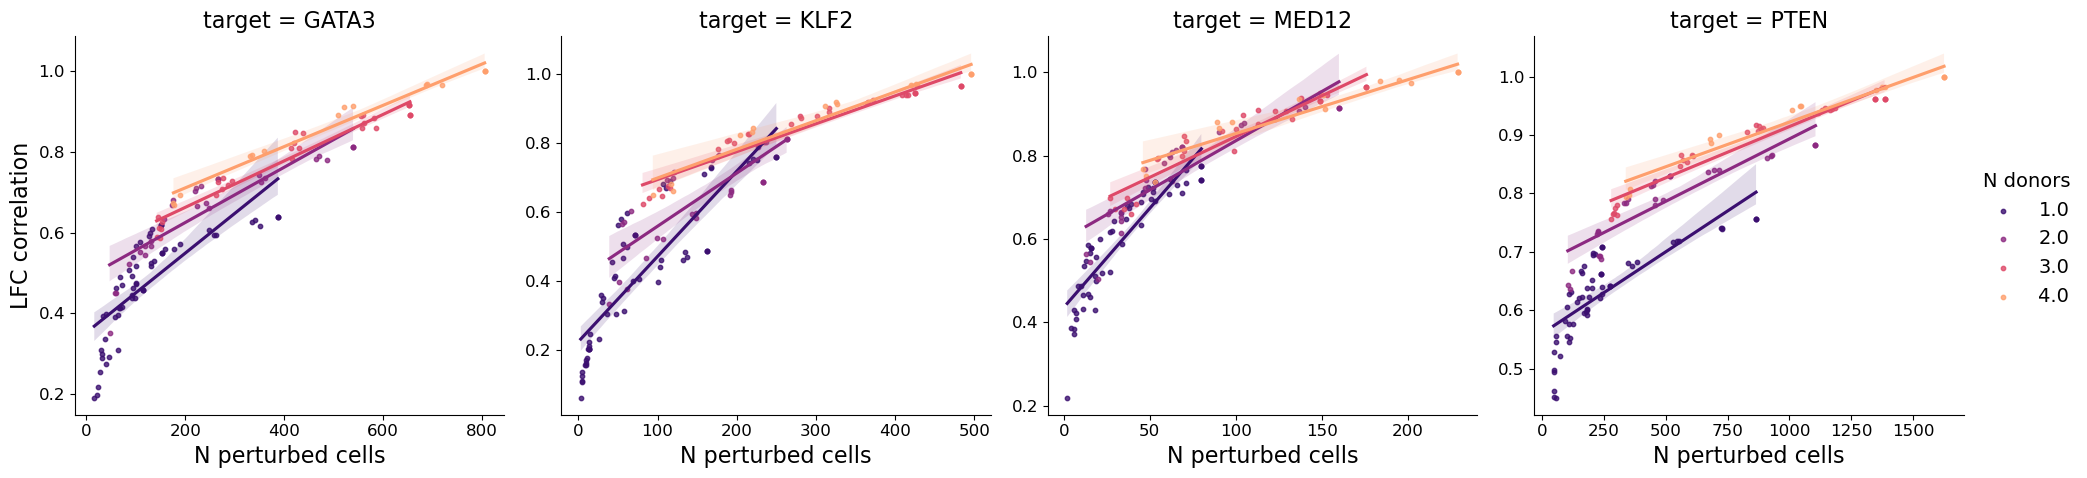

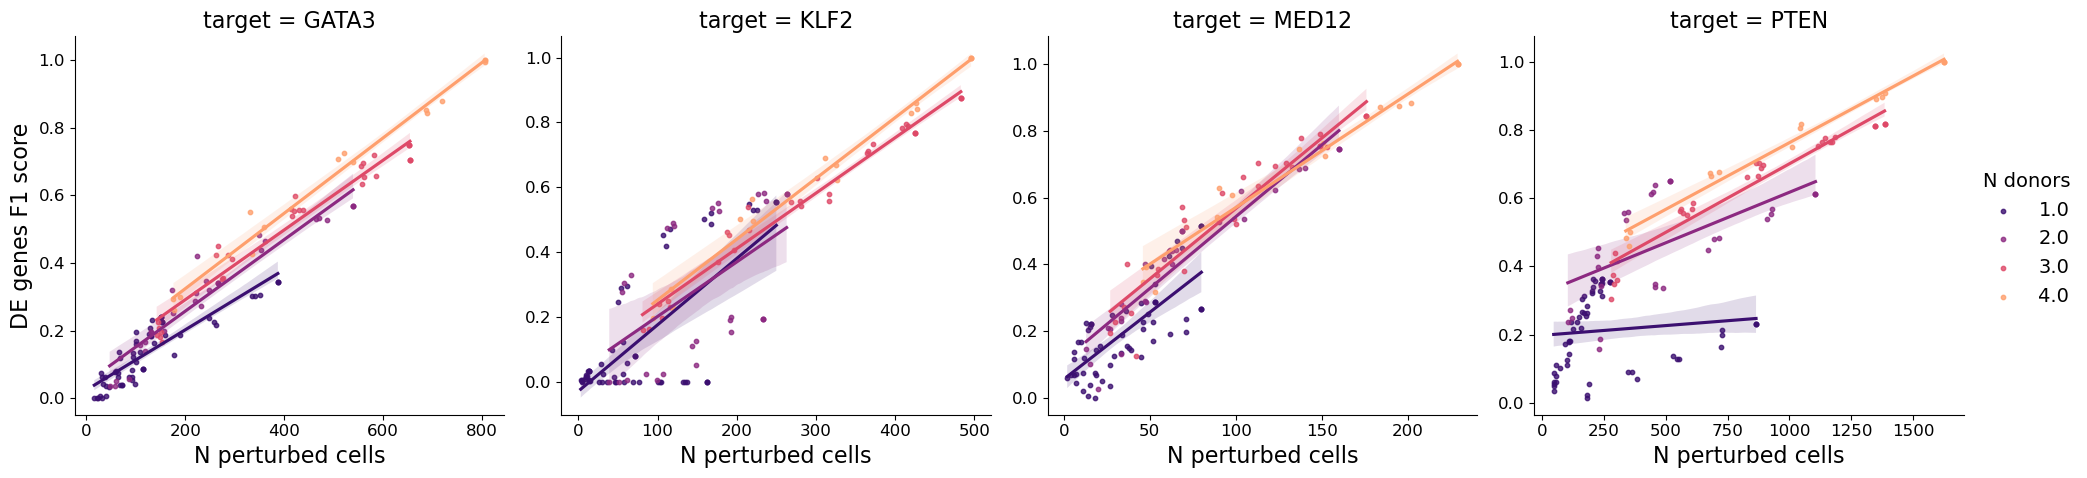

In [85]:
results_df['n_cells_repl'] = results_df['n_cells'] / results_df['n_donors']
results_df['N donors'] = results_df['n_donors']

# Create scatter plot with trend lines
plt.rcParams.update({'font.size': 14})  # base font size
plt.rcParams.update({'axes.labelsize': 16})  # axis labels
plt.rcParams.update({'xtick.labelsize': 12})  # x tick labels
plt.rcParams.update({'ytick.labelsize': 12})  # y tick labels

metrics_labels = {
    'lfc_correlation':'LFC correlation',
    'f1_score':'DE genes F1 score',
}
for m,l in metrics_labels.items():
    g = sns.lmplot(
        data=results_df,
        x='n_cells',
        y=m,
        hue='N donors',
        palette='magma',
        scatter=True,
        ci=95,
        col = 'target',
        scatter_kws={'s': 10},
        # lowess=True,
        sharex=False,
        sharey=False
    )
    g.set_axis_labels('N perturbed cells', l)
    plt.savefig(f'../results/power_analysis.all_donors_gold_standard.{m}.pdf')
    plt.savefig(f'../results/power_analysis.all_donors_gold_standard.{m}.png')

In [125]:
n_donors = 1
k = 'split5_seed3214'

for target in ['GATA3', 'PTEN']:
    for n_donors in [1,2]:
        target_de_res = all_de_res[(all_de_res['target_name'] == target) & (all_de_res['n_donors'] == n_donors) & (all_de_res.power_analysis_key == k)].copy()
        compare_df = target_de_res.pivot(columns='donors', index='variable', values='log_fc')
        corr_df = compare_df.corr().melt(ignore_index=False)
        corr_df['n_donors'] = n_donors
        corr_df['key'] = k
        print(corr_df)


              donors     value  n_donors              key
donors                                                   
CE0006864  CE0006864  1.000000         1  split5_seed3214
CE0008162  CE0006864  0.203832         1  split5_seed3214
CE0008678  CE0006864  0.212992         1  split5_seed3214
CE0010866  CE0006864  0.155901         1  split5_seed3214
CE0006864  CE0008162  0.203832         1  split5_seed3214
CE0008162  CE0008162  1.000000         1  split5_seed3214
CE0008678  CE0008162  0.169410         1  split5_seed3214
CE0010866  CE0008162  0.108985         1  split5_seed3214
CE0006864  CE0008678  0.212992         1  split5_seed3214
CE0008162  CE0008678  0.169410         1  split5_seed3214
CE0008678  CE0008678  1.000000         1  split5_seed3214
CE0010866  CE0008678  0.099175         1  split5_seed3214
CE0006864  CE0010866  0.155901         1  split5_seed3214
CE0008162  CE0010866  0.108985         1  split5_seed3214
CE0008678  CE0010866  0.099175         1  split5_seed3214
CE0010866  CE0

In [57]:
selected_perturbed_genes = ['GATA3', 'KLF2', 'STAT5B']
# Don't add the NTCs because these are not downsampled

sample_adatas = []
for f in tqdm(sample_h5ad_files):
    adata = sc.read_h5ad(f)
    selected_adata = adata[adata.obs['perturbed_gene_name'].isin(selected_perturbed_genes)]
    sample_adatas.append(selected_adata)
sample_adata = anndata.concat(sample_adatas)

  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
sample_adata.obs.value_counts('perturbed_gene_name')

perturbed_gene_name
KLF2      185
GATA3     104
STAT5B      5
Name: count, dtype: int64